# Introduction

Since this dataset is small about (3000 photos), it will be difficult for our model to learn patterns within the photos with few data points.<br>
With that being said, I'm going to use the concept of **Transfer Learning** to train the model to get really accurate results.
<br>
Transfer learning allows us to use pre-trained models that have done all the extensive, and time-consuming training on large datasets and reuse them for similar tasks. 

---

# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")
from util import plot_acc_loss

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

---

# Transfer Learning

Deep convolutional neural network models may result in some long training times.

Too save time I will re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks.

I'll start with the **EfficientNetB0** model which will use the weights from the **ImageNet** dataset. 
If time is permitted will compare with other pre-trained models

In [12]:
from tensorflow.keras.applications import EfficientNetB0

effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150,150,3))

**GlobalAveragePooling2D** : Similar to Max Pooling, uses the Average values instead of the Max value while *pooling*. This really decrease the computational load during training
<br><br>
**Dropout** : Excludes some neurons at each step from the layer making the neurons more independent from the neighbouring neurons. It helps in avoiding overfitting. Neurons to be excluded are selected at random. The **rate** parameter is the likelihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** : Output layer which classifies the image into 1 of the 4 possible classes.

In [13]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv_1 (TFOpLambda)  (None, 150, 150, 3)  0          ['normalization[0][0]']      

In [15]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [16]:
checkpoint = ModelCheckpoint("effnet_model.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto', verbose=1)

---

# Training The Model

In [17]:
X_train = np.load('../saves/data/x_train.npy')
y_train = np.load('../saves/data/y_train.npy')

In [18]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[checkpoint,reduce_lr])

Epoch 1/12
74/74 [==============================] - ETA: 0s - loss: 0.5162 - accuracy: 0.8101
Epoch 1: val_accuracy improved from -inf to 0.78244, saving model to effnet_model.h5
74/74 [==============================] - 136s 2s/step - loss: 0.5162 - accuracy: 0.8101 - val_loss: 0.8586 - val_accuracy: 0.7824 - lr: 0.0010
Epoch 2/12
74/74 [==============================] - ETA: 0s - loss: 0.2116 - accuracy: 0.9289
Epoch 2: val_accuracy improved from 0.78244 to 0.87405, saving model to effnet_model.h5
74/74 [==============================] - 129s 2s/step - loss: 0.2116 - accuracy: 0.9289 - val_loss: 0.5569 - val_accuracy: 0.8740 - lr: 0.0010
Epoch 3/12
74/74 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9536
Epoch 3: val_accuracy did not improve from 0.87405
74/74 [==============================] - 144s 2s/step - loss: 0.1345 - accuracy: 0.9536 - val_loss: 0.8397 - val_accuracy: 0.7824 - lr: 0.0010
Epoch 4/12
74/74 [==============================] - ETA: 0s - los

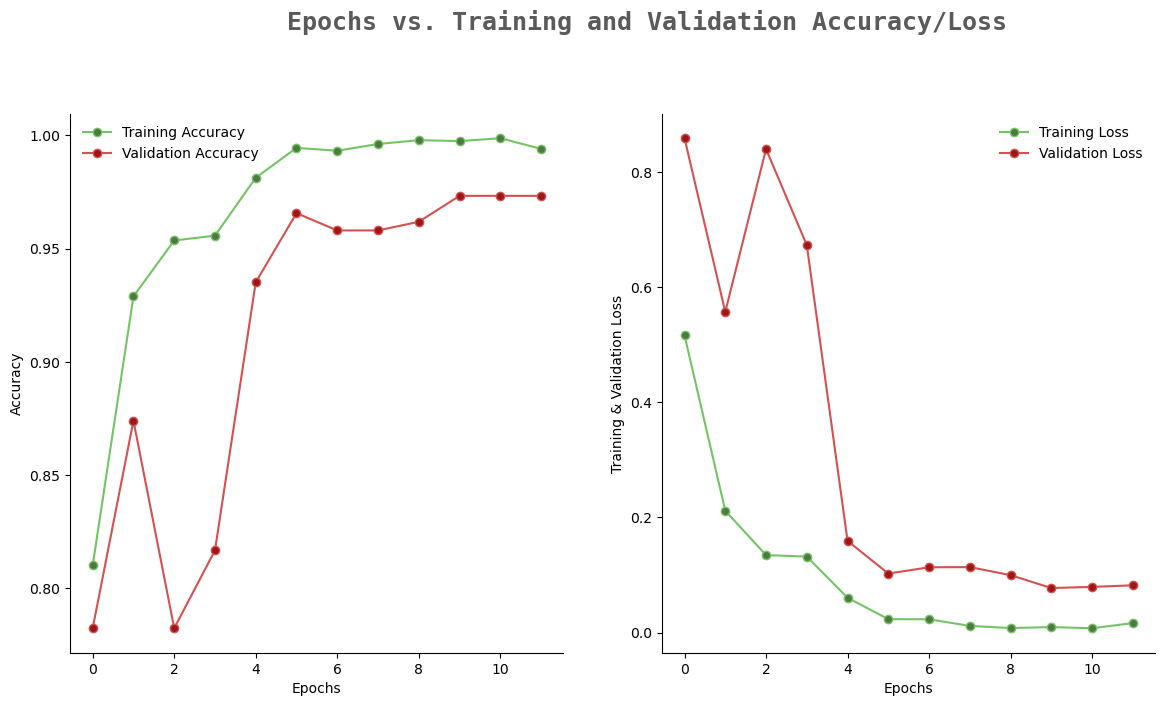

In [22]:
plot_acc_loss(history)

---

# Prediction

I've used the *argmax function* as each row from the prediction array contains four values for the respective labels. The **maximum** value which is in each row depicts the predicted output out of the 4 possible outcomes.<br>
So with *argmax*, I'm able to find out the index associated with the predicted outcome.

In [4]:
## load model saved from previous session
model = tf.keras.models.load_model('../saves/models/effnet_model.h5')

In [5]:
X_test = np.load('../saves/data/x_test.npy')
y_test = np.load('../saves/data/y_test.npy')

In [6]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

21/21 [==============================] - 8s 320ms/step


---

# Evaluation

0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [7]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       183
           1       0.98      1.00      0.99       100
           2       1.00      0.98      0.99       184
           3       1.00      1.00      1.00       186

    accuracy                           0.99       653
   macro avg       0.99      0.99      0.99       653
weighted avg       0.99      0.99      0.99       653



In [8]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

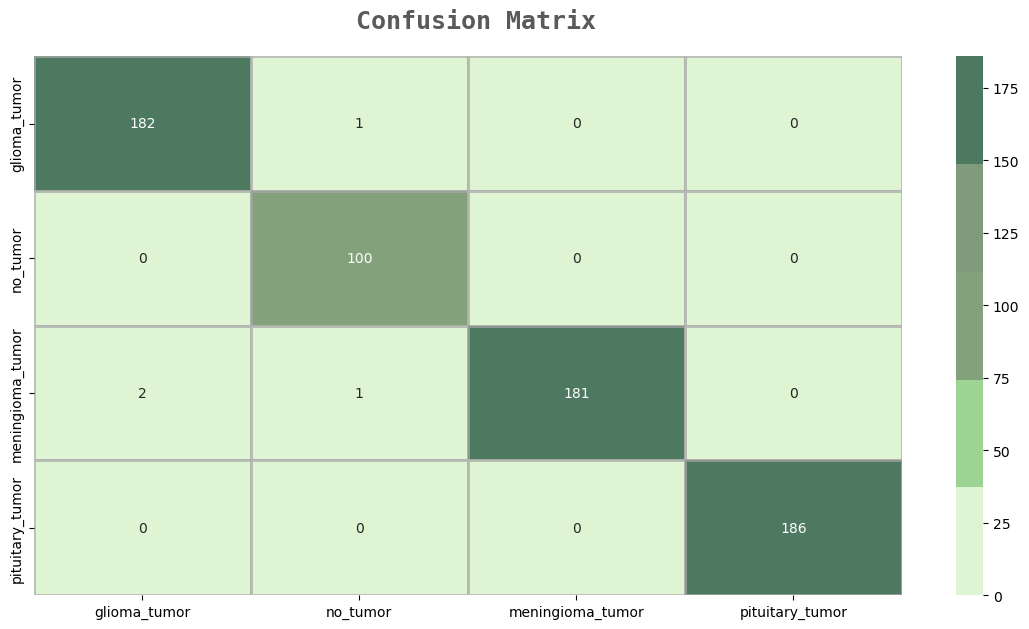

In [42]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new, pred),
            ax=ax,
            xticklabels=labels
            ,yticklabels=labels,
            annot=True,
            fmt='g',
            cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])

fig.text(s='       Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

---